# Sequence to Sequence Model (seq2seq) 

The most popular sequence-to-sequence task is translation: usually, from one natural language to another. In the last couple of years, commercial systems became surprisingly good at machine translation - check out, for example, Google Translate, Yandex Translate, DeepL Translator, Bing Microsoft Translator.

In [1]:
"""
(Practical tip) Table of contents can be compiled directly in jupyter notebooks using the following code:
I set an exception: if the package is in your installation you can import it otherwise you download it 
then import it.
"""
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu
    
"""
Output Table of contents to navigate easily in the notebook. 
For interested readers, the package also includes Ipython magic commands to go back to this cell
wherever you are in the notebook to look for cells faster
"""
add_notebook_menu()

## Imports

In [2]:
import unicodedata
import re
import numpy as np
import pandas as pd
import os
import io

In [3]:
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## Data

Data are available [here](http://www.manythings.org/anki/). They consist of a set of pairs in the following format:

  `May I borrow this book?`  `¿Puedo tomar prestado este libro?`

There are a variety of languages available, I have chosen to use the English-Spanish data to translate simple Spanish sentences into English. You can, of course, choose the language pair that interests you.

The data processing will consist of the following steps:

1. Removing special characters and adding a start and end token to each sentence.
1. Creating the vectorizer for each of the two languages

If you are using a word2vec, glove or fastext embedding, you will obviously need to use embeddings adapted to the languages chosen. For my part, I chose to work with the Keras embedding so as not to overload the code.

In [5]:
# Download dataset
def download_nmt(corpus="spa-eng"):
    path_to_zip = tf.keras.utils.get_file(corpus+".zip",
                                          origin="http://storage.googleapis.com/download.tensorflow.org/data/"+corpus+"eng.zip",
                                          extract=True)
    path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
    return path_to_file

file_path = download_nmt()

In [6]:
# Process the data
def step1(sent):
    # sent = on sentence in a language
    def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

    sent = unicode_to_ascii(sent.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    sent = re.sub(r"([?.!,¿])", r" \1 ", sent)
    sent = re.sub(r'[" "]+', " ", sent)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sent = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sent)

    return '<start> ' + sent.strip() + ' <end>' # Suppress extra space

In [7]:
# Loading data
def read_data(path, num_examples, split=0.2):
    # path : path to spa-eng.txt file
    # num_examples : Limit the total number of training example for faster training (set num_examples = len(lines) to use full data)
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    english_sentences, spanish_sentences= zip(*[[step1(sent) for sent in l.split('\t')]  for l in lines[:int((1+split)*num_examples)]])

    return np.array(spanish_sentences), np.array(english_sentences)

For good performance, it is necessary to have a large dataset but unfortunately, training a recurrent network is time consuming. We will therefore work initially with a reduced number of sentences.

In [8]:
num_examples = 700 # 600 for training and 100 for testing

spanish_sentences, english_sentences = read_data(file_path, num_examples, split=0.0)
test_spanish_sentences = spanish_sentences[num_examples-100:]
test_english_sentences = english_sentences[num_examples-100:]
spanish_sentences = spanish_sentences[:num_examples-100]
english_sentences = english_sentences[:num_examples-100]

""" try one sentence"""
spanish_sentences[100], english_sentences[100]

('<start> salga de aqui ! <end>', '<start> go away ! <end>')

In [9]:
# Search vocabulary and max_length for each language
def voc(lang):
    # a list of sentences in the same language
    lengths = [len(txt.split()) for txt in lang]
    vocab = set([w for txt in lang for w in txt.split()])  

    return max(lengths), list(vocab), len(vocab)+2 # for padding and OOV

max_length_spanish, vocab_spanish, vocab_size_spanish = voc(spanish_sentences)
max_length_english, vocab_english, vocab_size_english = voc(english_sentences)

pd.DataFrame({"lang":["english", "spanish"],
              "max_length":[max_length_english, max_length_spanish],
              "vocab_size": [vocab_size_english, vocab_size_spanish]}).head()

,lang,max_length,vocab_size
0,english,7,279
1,spanish,8,548


The vectorizer layers are initialized with the vocabulary of each of the two languages that we previously found in the train set. They could have been initialized with external vocabulary lists. For example :
* for English, https://www.kaggle.com/datasets/rtatman/english-word-frequency
* for Spanish, https://www.kaggle.com/datasets/rtatman/120-million-word-spanish-corpus

In [10]:
# Build vectorizer layer
english_vectorizer = layers.TextVectorization(standardize=None, output_mode='int',
                                              vocabulary=vocab_english,
                                              name="English_vect")

# Do the same for spanish
spanish_vectorizer = layers.TextVectorization(standardize=None, output_mode='int',
                                              vocabulary=vocab_spanish,
                                              name="Spanish_vect")

In [11]:
BATCH_SIZE = 32
embedding_dim = 50
latent_dim = 64
dropout=0.3

## Training model

Machine translation of languages is a difficult problem. The historical approach is based on rules at the lexical, syntactic or semantic level of transformation between a source language text and a target language text. These rules were produced by linguists.

Today, a more statistical approach to translation has been adopted. This involves unsupervised learning from a very large corpus. Given a text in the source language, e.g. French (f), what is the most likely translation in the target language, e.g. English (e)? The translation model p(f|e) is trained on a parallel corpus and the language model p(e) is computed on a target corpus only (English).

$$\hat{e} = {argmax}_e p(|f) = {argmax}_e p(f|e)p(e)$$

Neural machine translation emerged in 2014 by using neural network models to learn a statistical model for machine translation. Since then, networks have been discovering probabilities. The winning solution to this problem [Sutskever et al., 2014](https://proceedings.neurips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf) is the encoder-decoder architecture, which consists of encoding the source text into a fixed-length internal representation called context. Once encoded, different decoding systems can be used to translate the context into different languages. 

![Seq2Seq](https://miro.medium.com/max/720/0*DUQdq_qeOSndbIyM.jpg)

As both the encoder and decoder are recurrent neural networks, at each time step one of the RNNs performs processing, it updates its hidden state based on its inputs and previous inputs it has seen. The input to the encoder is the embedding vector of the current word of the input sentence, for example "I am a student". The hidden states of the encoder are the memory representation of the previous words. The last hidden state is actually the context that is passed to the decoder, which generates a clean sequence that represents the output "I am a student". The hidden states vectors is typically of size 200 or 300.

![training model](https://miro.medium.com/max/640/0*TARNagUeEdq1BdhZ.gif)

The RNNs models used in an encoder-decoder architecture can be unidirectional or bidirectional, single or multi-layered, simple vanilla RNN or LSTM or GRU. Below we show an example of deep multi-layer unidirectional RNN which uses LSTM as a recurrent unit. Here, “<s>” indicates the start of the decoding process while “</s>” tells the decoder to stop.

![stacked](https://miro.medium.com/max/720/0*RJy8h40IzRk5nb4G.jpg)

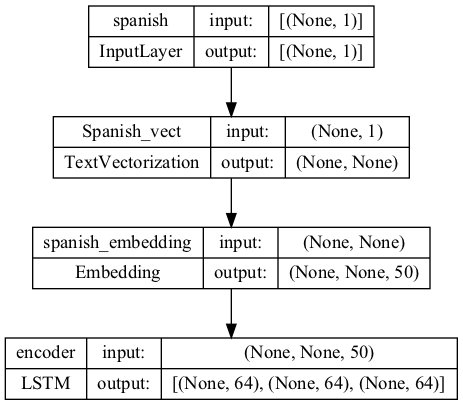

In [12]:
""" Encoder model """
""" Input: spanish sentence """
""" Output: latent representation of the sentence """

encoder_inputs = layers.Input(shape=(1,), dtype=tf.string, name="spanish")
encoder_vectorizer = spanish_vectorizer(encoder_inputs)
encoder_embedding = layers.Embedding(vocab_size_spanish, embedding_dim,
                                     name="spanish_embedding")(encoder_vectorizer)
_, encoder_state_h, encoder_state_c = layers.LSTM(latent_dim, return_sequences=False, return_state=True,
                           dropout=dropout, recurrent_dropout=dropout, name="encoder")(encoder_embedding)

encoder_model = Model(encoder_inputs, [encoder_state_h, encoder_state_c], name="encoder")

plot_model(encoder_model, show_shapes=True)

To build the decoder, two strategies are possible.

* Without teacher :
    * Decoder produces the output sequence one by one
    * For each output, the decoder consumes a context vector and an input
    * The initial context vector is created by the encoder
    * The initial input is a special symbol for the decoder to make it start, e.g. ‘start’
    * Using initial context and initial input, the decoder will generate the first output
    * For the next output, the decoder will use its current state as a context vector and generated (predicted) output as input

* with teacher. Exactly the same initialization principle as before, only the end is different :
    * Decoder produces the output sequence one by one
    * For each output, the decoder consumes a context vector and an input
    * The initial context vector is created by the encoder
    * The initial input is a special symbol for the decoder to make it start, e.g. ‘start’
    * Using initial context and initial input, the decoder will generate the first output
    * For the next output,
        * **the decoder will use its current state as context vector and generated (predicted) output as input**
        * **we (thedecoder_embedding = layers.Embedding(vocab_size_english, embedding_dim,

 teacher!) provide the correct output to the decoder as input**
        
The difference is: decoder use the context vector and the correct input to the next output rather than using its prediction in the previous cycle.

We implement this second strategies.

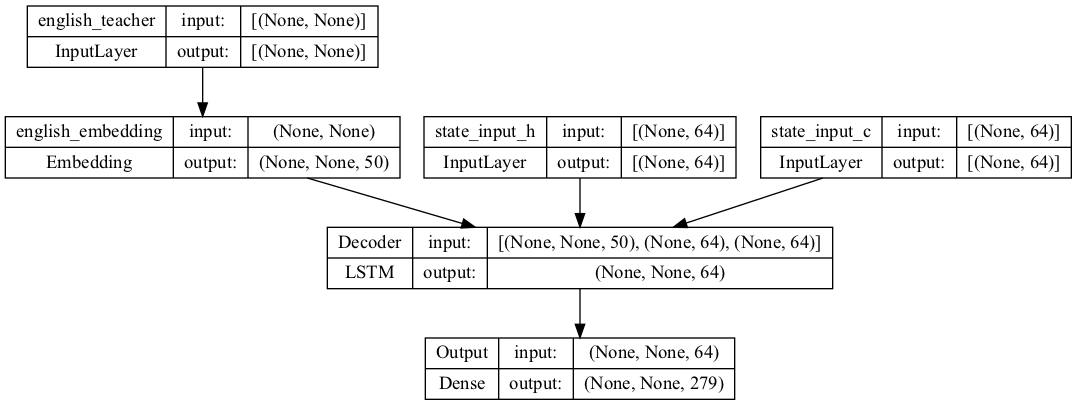

In [13]:
# Set up the decoder, using `encoder_states` as initial state.
# We'll need to force feed the two state variables into the decoder each step.
context_input_h = layers.Input(shape=(latent_dim,), name="state_input_h")
context_input_c = layers.Input(shape=(latent_dim,), name="state_input_c")
decoder_inputs = layers.Input(shape=(None,), dtype=tf.int32, name="english_teacher")
decoder_embedding = layers.Embedding(vocab_size_english, embedding_dim,
                                     name="english_embedding")(decoder_inputs)
decoder_outputs = layers.LSTM(latent_dim, return_sequences=True, return_state=False,
                                                                dropout=dropout, recurrent_dropout=dropout, name="Decoder")(decoder_embedding, initial_state=[context_input_h, context_input_c])
# Ouput layer
decoder_outputs = layers.Dense(vocab_size_english, activation='softmax', name="Output")(decoder_outputs)
                      
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
decoder_model_with_teacher = Model([context_input_h, context_input_c, decoder_inputs], decoder_outputs, name="decoder")

plot_model(decoder_model_with_teacher, show_shapes=True)

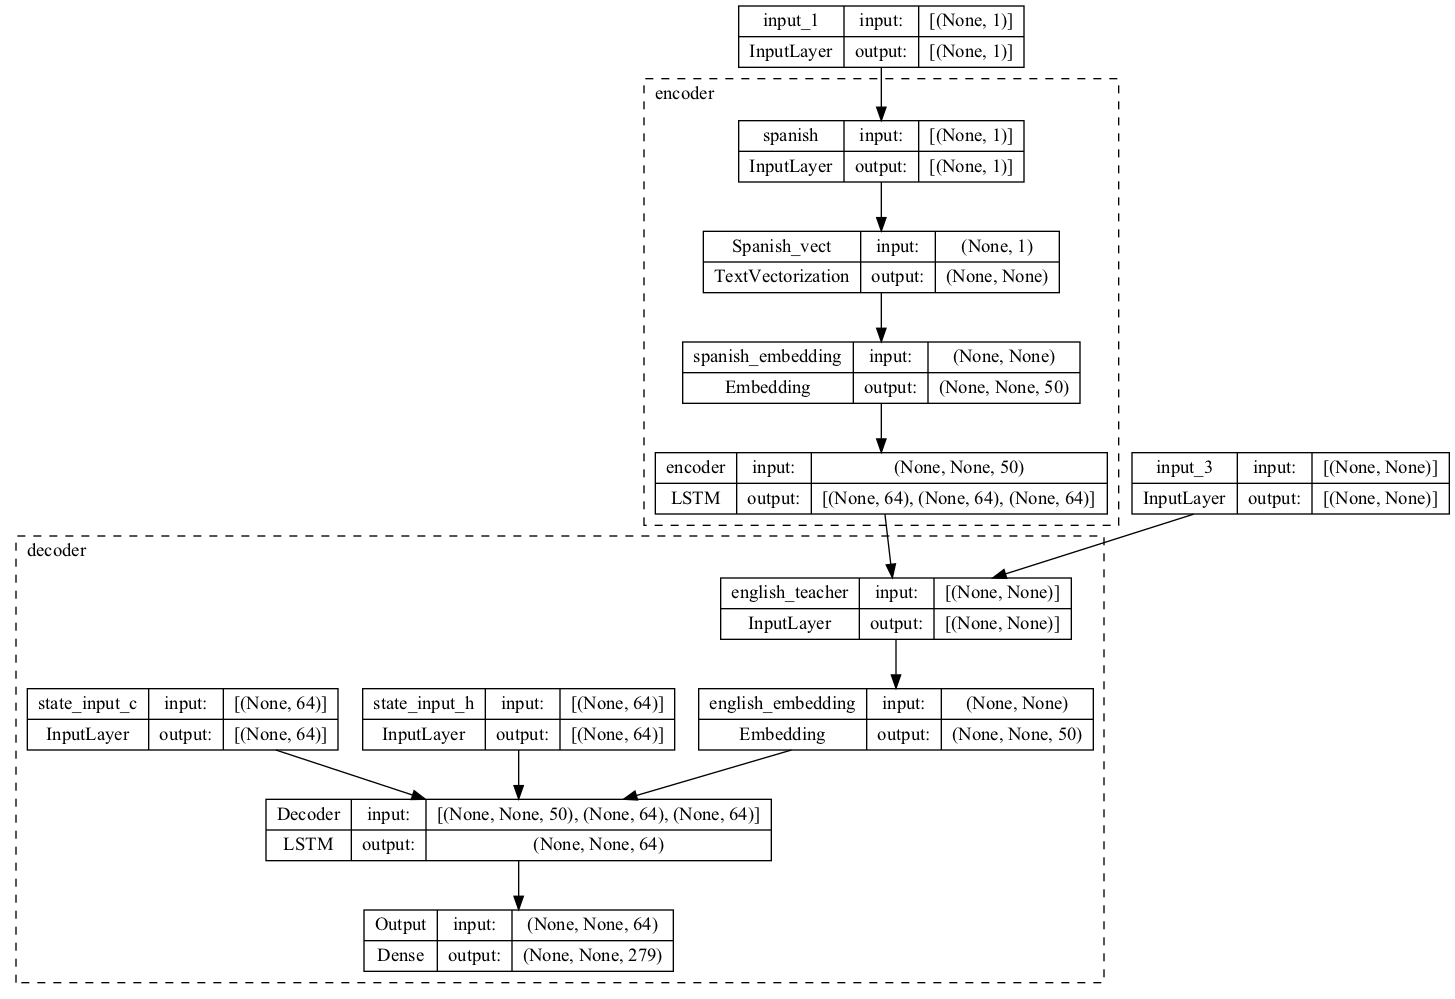

In [14]:
enc_inputs = layers.Input(shape=(1,), dtype=tf.string)
dec_inputs = layers.Input(shape=(None,), dtype=tf.int32)
enc_state_h, enc_state_c = encoder_model(enc_inputs)
dec_inputs = layers.Input(shape=(None,), dtype=tf.int32)
dec_outputs = decoder_model_with_teacher([enc_state_h, enc_state_c, dec_inputs])


model = Model([enc_inputs, dec_inputs], dec_outputs)

plot_model(model, show_shapes=True, expand_nested=True)

In [15]:
# Prepare training data with teacher forcing
# encoder_input_data is a 2D array of shape (None, max_english_sentence_length) containing a tokenization of the English sentences.
# decoder_input_data is a 2D array of shape (None, max_spanish_sentence_length) containing a tokenization of the Spanish sentences.
# decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t] will be the same as decoder_input_data[:, t-1].

english_teacher_enc = english_vectorizer(english_sentences).numpy() # Teacher
english_target_enc = np.zeros_like(english_teacher_enc)
english_target_enc[:,:-1] = english_teacher_enc[:,1:] # To predict
english_target_enc.shape

(600, 7)

In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

<font color=red>
We voluntarily choose to stop on loss in order to have overfitting: too little data to train (or too long training time if we take more data).

Obviously in real life... this is not something to do.
    
Nevertheless, we keep a validation set to see the overtraining
</font>

In [17]:
# Configure the model and start training
# Stop training with early stopping with patience of 20
callbacks_list = [EarlyStopping(monitor='loss', mode='min', min_delta=0.0001,
                                patience=5, restore_best_weights=True, verbose=1,
                                )]
history = model.fit([spanish_sentences, english_teacher_enc], english_target_enc,
                    validation_split=0.1,
                    epochs=1000, batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/1000
17/17 [==============================] - 4s 40ms/step - loss: 4.5359 - accuracy: 0.3823 - val_loss: 3.2386 - val_accuracy: 0.2857
Epoch 2/1000
17/17 [==============================] - 0s 15ms/step - loss: 2.6221 - accuracy: 0.4066 - val_loss: 3.0353 - val_accuracy: 0.2857
Epoch 3/1000
17/17 [==============================] - 0s 14ms/step - loss: 2.4033 - accuracy: 0.4116 - val_loss: 2.8979 - val_accuracy: 0.2857
Epoch 4/1000
17/17 [==============================] - 0s 14ms/step - loss: 2.2691 - accuracy: 0.4352 - val_loss: 2.7598 - val_accuracy: 0.2952
Epoch 5/1000
17/17 [==============================] - 0s 14ms/step - loss: 2.1692 - accuracy: 0.5093 - val_loss: 2.7254 - val_accuracy: 0.4238
Epoch 6/1000
17/17 [==============================] - 0s 15ms/step - loss: 2.0860 - accuracy: 0.5680 - val_loss: 2.6203 - val_accuracy: 0.4381
Epoch 7/1000
17/17 [==============================] - 0s 14ms/step - loss: 2.0147 - accuracy: 0.6045 - val_loss: 2.6486 - val_accuracy: 0.4381

Epoch 58/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.8443 - accuracy: 0.8013 - val_loss: 2.4095 - val_accuracy: 0.7000
Epoch 59/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.8321 - accuracy: 0.8011 - val_loss: 2.4161 - val_accuracy: 0.7000
Epoch 60/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.8252 - accuracy: 0.8011 - val_loss: 2.4103 - val_accuracy: 0.7024
Epoch 61/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.8126 - accuracy: 0.8032 - val_loss: 2.4414 - val_accuracy: 0.7000
Epoch 62/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.8097 - accuracy: 0.8074 - val_loss: 2.4666 - val_accuracy: 0.6952
Epoch 63/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.7928 - accuracy: 0.8111 - val_loss: 2.4560 - val_accuracy: 0.6952
Epoch 64/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.7886 - accuracy: 0.8056 - val_loss: 2.4454 - val_accuracy:

Epoch 115/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.5041 - accuracy: 0.8646 - val_loss: 2.7763 - val_accuracy: 0.6881
Epoch 116/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.5022 - accuracy: 0.8675 - val_loss: 2.7179 - val_accuracy: 0.6976
Epoch 117/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.5003 - accuracy: 0.8690 - val_loss: 2.7843 - val_accuracy: 0.6881
Epoch 118/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.4954 - accuracy: 0.8704 - val_loss: 2.7746 - val_accuracy: 0.6929
Epoch 119/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.4920 - accuracy: 0.8720 - val_loss: 2.7464 - val_accuracy: 0.6976
Epoch 120/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.4866 - accuracy: 0.8706 - val_loss: 2.7896 - val_accuracy: 0.6905
Epoch 121/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.4884 - accuracy: 0.8706 - val_loss: 2.7739 - val_ac

17/17 [==============================] - 0s 14ms/step - loss: 0.3525 - accuracy: 0.8992 - val_loss: 2.9388 - val_accuracy: 0.6952
Epoch 172/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.3433 - accuracy: 0.9026 - val_loss: 2.9412 - val_accuracy: 0.6976
Epoch 173/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.3420 - accuracy: 0.9053 - val_loss: 2.8930 - val_accuracy: 0.6952
Epoch 174/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.3457 - accuracy: 0.8976 - val_loss: 2.9145 - val_accuracy: 0.6952
Epoch 175/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.3378 - accuracy: 0.9082 - val_loss: 2.9318 - val_accuracy: 0.7000
Epoch 176/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.3408 - accuracy: 0.9053 - val_loss: 2.9073 - val_accuracy: 0.7048
Epoch 177/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.3377 - accuracy: 0.9048 - val_loss: 2.9101 - val_accuracy: 0.7048


17/17 [==============================] - 0s 14ms/step - loss: 0.2481 - accuracy: 0.9280 - val_loss: 2.9481 - val_accuracy: 0.7167
Epoch 228/1000
17/17 [==============================] - 0s 15ms/step - loss: 0.2459 - accuracy: 0.9302 - val_loss: 3.0038 - val_accuracy: 0.7000
Epoch 229/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.2539 - accuracy: 0.9265 - val_loss: 3.0258 - val_accuracy: 0.7071
Epoch 230/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.2482 - accuracy: 0.9270 - val_loss: 2.9994 - val_accuracy: 0.7071
Epoch 231/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.2446 - accuracy: 0.9286 - val_loss: 3.0069 - val_accuracy: 0.7095
Epoch 232/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.2439 - accuracy: 0.9272 - val_loss: 3.0154 - val_accuracy: 0.7024
Epoch 233/1000
17/17 [==============================] - 0s 13ms/step - loss: 0.2368 - accuracy: 0.9328 - val_loss: 3.0457 - val_accuracy: 0.7071


17/17 [==============================] - 0s 15ms/step - loss: 0.1887 - accuracy: 0.9452 - val_loss: 3.0821 - val_accuracy: 0.7119
Epoch 284/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.1840 - accuracy: 0.9458 - val_loss: 3.1059 - val_accuracy: 0.7095
Epoch 285/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.1852 - accuracy: 0.9439 - val_loss: 3.0628 - val_accuracy: 0.7071
Epoch 286/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.1801 - accuracy: 0.9492 - val_loss: 3.0847 - val_accuracy: 0.7000
Epoch 287/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.1787 - accuracy: 0.9481 - val_loss: 3.0276 - val_accuracy: 0.7190
Epoch 288/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.1754 - accuracy: 0.9508 - val_loss: 3.1013 - val_accuracy: 0.7024
Epoch 289/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.1777 - accuracy: 0.9474 - val_loss: 3.0789 - val_accuracy: 0.7095


In [18]:
model.save('seq2seq-variable')

INFO:tensorflow:Assets written to: seq2seq-variable/assets


(0.159834623336792, 0.956084668636322)

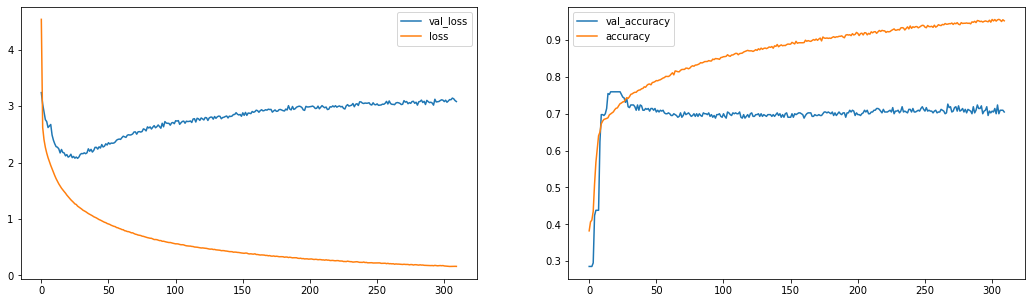

In [19]:
# Babysit the model
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

pd.DataFrame({'val_loss':history.history['val_loss'],
              'loss':history.history['loss'],
             }).plot(ax=ax1)
pd.DataFrame({'val_accuracy':history.history['val_accuracy'],
              'accuracy':history.history['accuracy']
             }).plot(ax=ax2)

min(history.history['loss']), max(history.history['accuracy'])

## Inference

![inference model](https://blog.keras.io/img/seq2seq/seq2seq-inference.png)

In [20]:
# To decode, you must find the word corresponding to the token
token2word = {token:word for token, word in enumerate(english_vectorizer.get_vocabulary())}
word2token = {v:k for k, v in token2word.items()}

def decode_english_sentence(lang):
    return " ".join([token2word[t] for t in lang]).strip()

In [21]:
def translate(spanish_sent, preprocessing=False):
    # Encode the input as state vectors.
    if not preprocessing:
        spanish_sent = step1(spanish_sent)
    
    # Build teacher for first step i.e. populate the first word of target sequence with "<start>".
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = word2token["<start>"]
    
    # Sampling loop for decoding one sentence.
    stop_condition = False
    
    while not stop_condition:
        # Predict
        predicted_tokens = model.predict([np.array(spanish_sent, ndmin=2), target_seq], verbose=0)
        predicted_tokens = np.argmax(predicted_tokens, axis=2)
        
        # Update the target sequence.
        sampled_token_index = predicted_tokens[0, -1]
        target_seq = np.append(target_seq[0], [sampled_token_index]).reshape(1,-1)
        
        # Exit condition: either hit max length
        # or find stop character.
        if sampled_token_index==word2token['<end>'] or len(target_seq[0])==max_length_english:
            stop_condition = True

    return decode_english_sentence(target_seq[0])

In [22]:
# Search for the correct sentences.
from tqdm import tqdm

correct = []
incorrect = []
for i, (spanish_sent, english_sent) in tqdm(enumerate(zip(spanish_sentences, english_sentences))):
    decoded_sentence = translate(spanish_sent)
    decoded = english_vectorizer(decoded_sentence).numpy()
    original = english_vectorizer(english_sent).numpy()
    if len(decoded)==len(original) and sum(decoded==original)==len(original):
        correct += [i]
    else:
        incorrect += [i]

600it [01:23,  7.22it/s]


In [23]:
len(correct), len(correct)/len(spanish_sentences)*100

(342, 56.99999999999999)

In [24]:
# Decode some correct sentences
for spanish_sent, english_sent in zip(spanish_sentences[correct[:10]], english_sentences[correct[:10]]):
    print("="*50)
    print(spanish_sent, "-->", english_sent)
    decoded_sentence = translate(spanish_sent)
    print(english_sent, "???", decoded_sentence)

<start> vete . <end> --> <start> go . <end>
<start> go . <end> ??? <start> go . <end>
<start> vaya . <end> --> <start> go . <end>
<start> go . <end> ??? <start> go . <end>
<start> fuego ! <end> --> <start> fire ! <end>
<start> fire ! <end> ??? <start> fire ! <end>
<start> incendio ! <end> --> <start> fire ! <end>
<start> fire ! <end> ??? <start> fire ! <end>
<start> disparad ! <end> --> <start> fire ! <end>
<start> fire ! <end> ??? <start> fire ! <end>
<start> ayuda ! <end> --> <start> help ! <end>
<start> help ! <end> ??? <start> help ! <end>
<start> socorro ! auxilio ! <end> --> <start> help ! <end>
<start> help ! <end> ??? <start> help ! <end>
<start> auxilio ! <end> --> <start> help ! <end>
<start> help ! <end> ??? <start> help ! <end>
<start> parad ! <end> --> <start> stop ! <end>
<start> stop ! <end> ??? <start> stop ! <end>
<start> para ! <end> --> <start> stop ! <end>
<start> stop ! <end> ??? <start> stop ! <end>


In [25]:
# Decode some incorrect sentences
for spanish_sent, english_sent in zip(spanish_sentences[incorrect[-10:]], english_sentences[incorrect[-10:]]):
    print("="*50)
    print(spanish_sent, "-->", english_sent)
    decoded_sentence = translate(spanish_sent)
    print(english_sent, "???", decoded_sentence)

<start> estoy quebrado . <end> --> <start> i m broke . <end>
<start> i m broke . <end> ??? <start> i m full . <end>
<start> estoy sin blanca . <end> --> <start> i m broke . <end>
<start> i m broke . <end> ??? <start> i m back . <end>
<start> no tengo blanca . <end> --> <start> i m broke . <end>
<start> i m broke . <end> ??? <start> don t ask . <end>
<start> estoy loco . <end> --> <start> i m crazy . <end>
<start> i m crazy . <end> ??? <start> i m full . <end>
<start> estoy borracho . <end> --> <start> i m drunk . <end>
<start> i m drunk . <end> ??? <start> i m back . <end>
<start> estoy tomada . <end> --> <start> i m drunk . <end>
<start> i m drunk . <end> ??? <start> i m back . <end>
<start> estoy prendida . <end> --> <start> i m drunk . <end>
<start> i m drunk . <end> ??? <start> i m back . <end>
<start> me estoy muriendo . <end> --> <start> i m dying . <end>
<start> i m dying . <end> ??? <start> i m here . <end>
<start> soy el primero . <end> --> <start> i m first . <end>
<start> i 

<font color="red">
<h2>Your work:</h2>
    <ul>
        <li> Adapt the previous model to use GRU cells instead of LSTM cells.</li>
        <li> If possible, build a stacked GRU model.</li>
        <li> Then, adapt the your previous model to build a seq2seq model capable of translating a text from one language to another but working at the character level and not at the word level.</li>
    </ul>
</font>